In [2]:
import torch
import numpy as np
import gpytorch
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(1)

# 高斯过程拟合四件套
1. 初始化数据
2. 定义GPRegressor类
3. 定义核函数和协方差矩阵
4. 训练模型并绘制结果
```
y_init = f(X_init, noise=0.5)
model = GPRegressor(X_init, y_init, mean_fn, kernel_fn)
train(model, X_init, y_init)
plot_model(model)
```


In [3]:
# we will use the simplest form of GP model: exact inference
class GPRegressor(gpytorch.models.ExactGP):
    def __init__(self, X, y, mean, kernel, likelihood=None):
        # choose the standard observation model as required by exact GP inference
        if likelihood is None:
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
        # initiate the superclass ExactGP to refresh the posterior
        super().__init__(X, y, likelihood)
        # store attributes
        self.mean = mean
        self.kernel = kernel
        self.likelihood = likelihood
    
    # compute the posterior distribution after conditioning on the training data
    def forward(self, x):
        mean_x = self.mean(x)
        covar_x = self.kernel(x)
        # return a posterior multivariate normal distribution
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    # compute the marginal predictive distribution of y given x
    def predict(self, x):
        # set to evaluation mode
        self.eval()
        # perform inference without gradient propagation
        with torch.no_grad():
            # get posterior distribution p(f|x)
            pred = self(x)
            # convert posterior distribution p(f|x) to p(y|x)
            return self.likelihood(pred)
        

def plot_model(model, xlim=None):
    """
    Plot 1D GP model
    we
    input:
    model : gpytorch.models.GP
    xlim : the limit of x axis, tuple(float, float) or None
    """
    # extract training data in numpy format
    X_train = model.train_inputs[0].cpu().numpy()
    y_train = model.train_targets.cpu().numpy()
    # obtain range of x axis
    if xlim is None:
        xmin = float(X_train.min())
        xmax = float(X_train.max())
        x_range = xmax - xmin
        xlim = [xmin - 0.05 * x_range,
                xmax + 0.05 * x_range]
    # create a list of equally spaced input locations following the same dtype as parameters
    model_tensor_example = list(model.parameters())[0]
    X_plot = torch.linspace(xlim[0], xlim[1], 200).to(model_tensor_example)  
    # 当你执行 X_plot.to(model_tensor_example) 时，这里的 to 方法的作用是确保 X_plot 张量和 model_tensor_example 参数位于同一个设备上。由于 model_tensor_example 是一个 Parameter 对象，它已经存在于某个设备上（例如 GPU 或 CPU），而 X_plot 是新创建的张量，它默认存在于当前的默认设备上（通常是 CPU）
    # generate predictive posterior distribution
    """
    model.eval() 是 PyTorch 中的一个方法，用于将模型设置为评估模式。当你调用这个方法时，模型会进入一个特殊的状态，这个状态下模型中的某些层（主要是包含在模型中的 BatchNorm 和 Dropout 层）的行为会发生变化。

    具体来说，model.eval() 执行以下操作：

    对于 BatchNorm 层：在训练模式下，BatchNorm 层会计算当前批次的均值和方差，并使用这些统计数据来标准化数据。同时，它会更新层内部维护的均值和方差的运行估计值。当模型设置为评估模式时，BatchNorm 层会使用这些运行估计值来标准化数据，而不是使用当前批次的统计数据。这意味着在评估或测试时，数据的标准化方式与训练过程中使用的统计数据一致，从而保证了模型行为的一致性。

    对于 Dropout 层：在训练模式下，Dropout 层会随机将输入的一部分元素置为零，以减少模型对特定训练样本的依赖，从而防止过拟合。然而，在评估或测试模式下，我们通常希望模型使用所有数据进行前向传播，而不是随机丢弃一部分数据。因此，当模型设置为评估模式时，Dropout 层会被禁用，即不再随机丢弃输入的元素。

    """
    model.eval()
    predictive_distribution = model.predict(X_plot)
    # obtain mean, upper and lower bounds
    lower, upper = predictive_distribution.confidence_region()
    prediction = predictive_distribution.mean.cpu().numpy()
    X_plot = X_plot.numpy()

    plt.scatter(X_train, y_train, marker='x', c='k')
    plt.plot(X_plot, prediction)
    plt.fill_between(X_plot, lower, upper, alpha=0.1)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)


# fine tune hyperparameters (lengthscale and noise variance) by optimizing MLE
def train(model, X, y, n_epochs=100, lr=0.3, verbose=True):
    # switch to model training mode
    model.train()
    # Use the adam optimizer
    training_parameters = model.parameters()
    optimizer = torch.optim.Adamax(training_parameters, lr=lr)
    # 创建一个用于计算边际对数似然（Marginal Log Likelihood, MLL）的对象。MML是高斯过程模型中用于评估模型拟合优度的指标。
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model) 
    # start the training loop
    for e in range(n_epochs):
        # clear gradients to prevent gradient accumulation
        optimizer.zero_grad()
        # get posterior distribution p(f|x)
        out = model(X)
        # get negated exact marginal log likelihood p(y|x)
        loss = -mll(out, y)
        # caculated gradients using autograd
        loss.backward()
        # perform gradient update
        optimizer.step()
        # print optimization log
        if verbose:
            if e % 5 == 0:
                lengthscale = model.kernel.base_kernel.lengthscale.squeeze(0).detach().cpu().numpy()
                print(f"Epoch: {e}, loss: {loss.item():.3f}, lengthscale: {lengthscale[0]:.3f}, noise: {model.likelihood.noise.item():.3f}")
                # print(f"Loss: {loss.item():.3f}, lengthscale: {lengthscale}")   

## RBFKernel with different lengthscales


In [4]:
def plot_kernel(kernel, xlim=None, ax=None):
    if xlim is None:
        xlim = [-3, 3]
    x = torch.linspace(xlim[0], xlim[1], 100)
    # call the evaluate() function to perform the actual evaluation
    with torch.no_grad():
        K = kernel(x, torch.ones((1))).evaluate().reshape(-1, 1)
    """这里调用了一个名为kernel的函数，它接受两个参数：x和torch.ones((1))。
    x是一个输入点集，可能是一个张量（Tensor），代表一组观测数据。torch.ones((1))创建了一个值为1的张量，形状为单行（1行）。
    这里为什么使用ones？ 因为这里是评估不同的lengthscale对gpr的影响，无论哪一个点都可以，ones是最简单的。。
    """

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    ax.plot(x.numpy(), K.cpu().numpy())

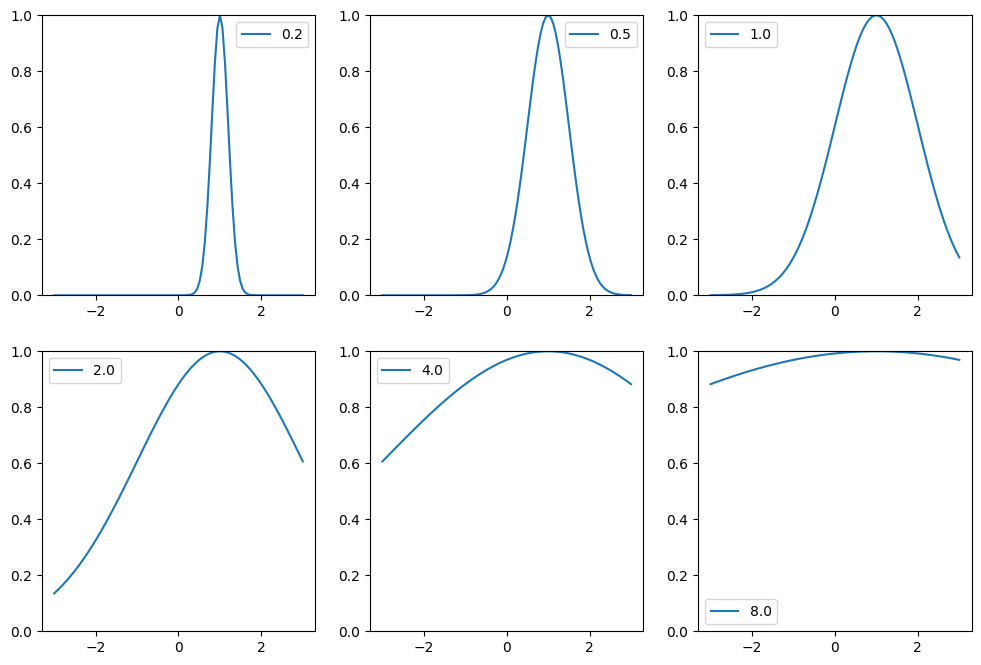

In [5]:
k = gpytorch.kernels.RBFKernel()
all_lengthscale = np.asarray([0.2, 0.5, 1, 2, 4, 8])
figure, axes = plt.subplots(2, 3, figsize=(12, 8))
for tmp_lengthscale, ax in zip(all_lengthscale, axes.ravel()): 
    # ravel方法用于将多维数组或轴展平为一维数组
    k.lengthscale = tmp_lengthscale
    plot_kernel(k, ax=ax)
    ax.set_ylim([0, 1])
    ax.legend([tmp_lengthscale])

# Different Kernels
在机器学习中，特别是在支持向量机（SVM）和高斯过程（Gaussian Process, GP）等核方法中，"核"（Kernel）是一种特殊的函数，用于测量不同数据点之间的相似性或距离。核函数的选择对模型的性能有重要影响。以下是您列出的每种核函数的简要解释：

1. **线性核（Linear Kernel）**:
   - 形式：`K(x, y) = x^T y + c`（其中 `c` 是一个常数项）
   - 描述：最简单的核函数，它计算两个向量的点积加一个常数项。适用于线性可分的数据。

2. **多项式核（Polynomial Kernel）**:
   - 形式：`K(x, y) = (gamma * x^T y + c)^ d`（其中 `gamma` 和 `d` 是参数）
   - 描述：允许模型学习非线性特征，通过将输入映射到更高维的空间。

3. **径向基函数核（RBF Kernel）或高斯核**:
   - 形式：`K(x, y) = exp(-gamma * ||x - y||^2)`（其中 `gamma` 是参数）
   - 描述：最常用的核之一，它测量两个点在欧几里得空间中的距离，具有良好的平滑性质。


4. **有理二次核（Rational Quadratic Kernel）**:
   - 形式：`K(x, y) = (1 + ||x - y||^2 / (2 * alpha^2))^(-beta)`（其中 `alpha` 和 `beta` 是参数）
   - 描述：结合了高斯核和线性核的特点，适用于不同的数据集。

5. **Matern 核**:
   - 形式：`K(x, y) = (1 + sqrt(3) * ||x - y|| / phi)^alpha * exp(-sqrt(3) * ||x - y|| / phi)`（其中 `phi` 和 `alpha` 是参数）
   - 描述：具有不同的平滑度，`alpha` 值越大，核函数越平滑。

6. **周期核（Periodic Kernel）**:
    - 形式：`K(x, y) = exp(-gamma * ||x - y||) * cos(omega * ||x - y||)`（其中 `gamma`、`omega` 是参数）
    - 描述：结合了周期性和 RBF 核的特点，适用于具有周期性特征的数据。


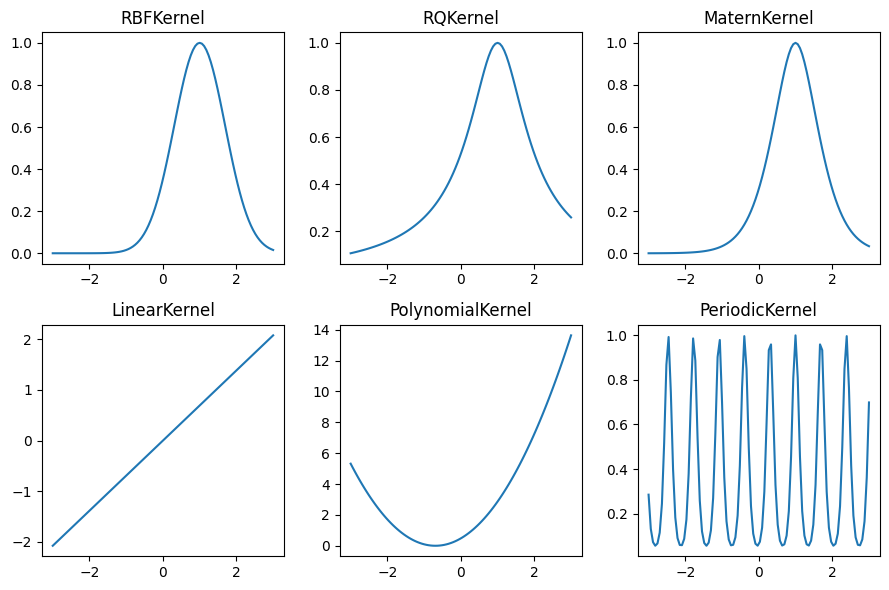

In [6]:
covariance_functions = [gpytorch.kernels.RBFKernel(), 
                        gpytorch.kernels.RQKernel(),
                        gpytorch.kernels.MaternKernel(nu=5/2), 
                        gpytorch.kernels.LinearKernel(power=1),
                        gpytorch.kernels.PolynomialKernel(power=2), 
                        gpytorch.kernels.PeriodicKernel()
                       ]
figure, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.ravel()
for i, k in enumerate(covariance_functions):
    plot_kernel(k, ax=axes[i])
    axes[i].set_title(str(k).split('(')[0])
figure.tight_layout()

## Combining different kernel functions

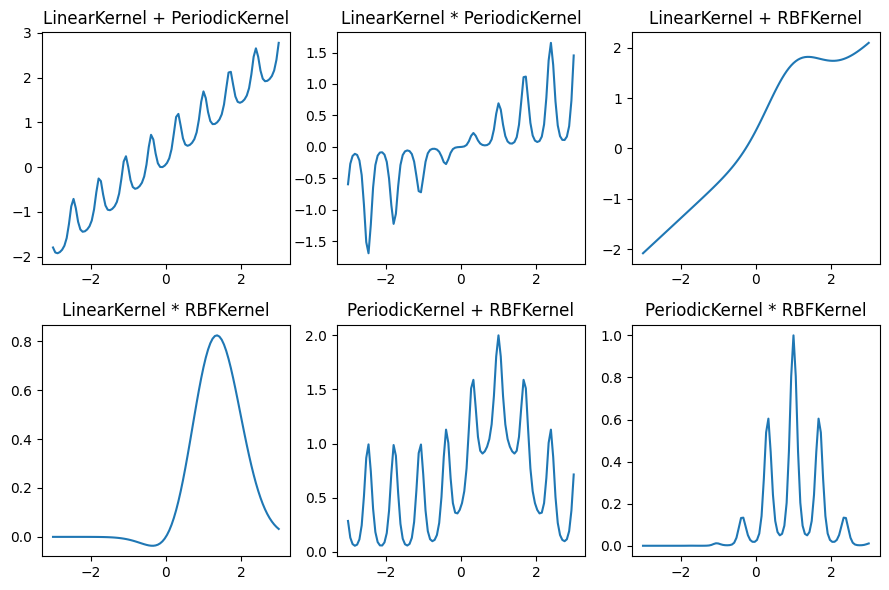

In [7]:
kernel_functions = [gpytorch.kernels.LinearKernel(power=1), 
                        gpytorch.kernels.PeriodicKernel(),
                        gpytorch.kernels.RBFKernel()]
# overload the + and * operators
operations = {'+': lambda x, y: x + y,
              '*': lambda x, y: x * y}
figure, axes = plt.subplots(len(operations), len(kernel_functions), figsize=(9, 6))

import itertools
axes = axes.ravel()
count = 0
# iterate through each unique combinations of kernels and operators
for j, base_kernels in enumerate(itertools.combinations(kernel_functions, 2)):
    for k, (op_name, op) in enumerate(operations.items()):
        kernel = op(base_kernels[0], base_kernels[1])
        plot_kernel(kernel, ax=axes[count])
        kernel_names = [
            str(base_kernels[i]).split('(')[0] for i in [0, 1]
        ]
        axes[count].set_title('{} {} {}'.format(kernel_names[0], op_name, 
                                                kernel_names[1]), fontsize=12)
        count += 1
figure.tight_layout()

# using combined kernels to fit the data

书中提供了一个例子，预测飞机乘客数量。数据在airline.npz。



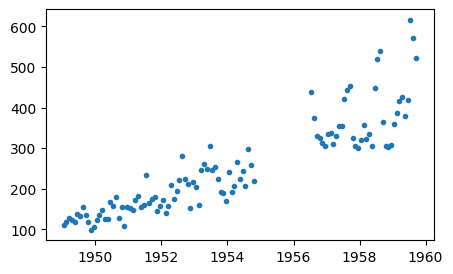

In [26]:
data = np.load('airline.npz')
X = torch.tensor(data['X'])
y = torch.tensor(data['y']).squeeze()
train_indices = list(range(70)) + list(range(90, 129))
test_indices = range(70, 90)
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]
plt.figure(figsize=(5, 3))
plt.plot(X_train.numpy(), y_train.numpy(), '.')

### 使用 RBF Kernel

Epoch: 0, loss: 5027.045, lengthscale: 0.854, noise: 0.854
Epoch: 5, loss: 1891.856, lengthscale: 1.485, noise: 1.578
Epoch: 10, loss: 1275.795, lengthscale: 1.883, noise: 2.129
Epoch: 15, loss: 1023.459, lengthscale: 2.153, noise: 2.545
Epoch: 20, loss: 888.701, lengthscale: 2.347, noise: 2.867
Epoch: 25, loss: 805.626, lengthscale: 2.492, noise: 3.124
Epoch: 30, loss: 749.163, lengthscale: 2.605, noise: 3.334
Epoch: 35, loss: 707.903, lengthscale: 2.695, noise: 3.510
Epoch: 40, loss: 676.008, lengthscale: 2.770, noise: 3.664
Epoch: 45, loss: 650.234, lengthscale: 2.835, noise: 3.799
Epoch: 50, loss: 628.666, lengthscale: 2.891, noise: 3.922
Epoch: 55, loss: 610.117, lengthscale: 2.942, noise: 4.035
Epoch: 60, loss: 593.823, lengthscale: 2.988, noise: 4.140
Epoch: 65, loss: 579.271, lengthscale: 3.031, noise: 4.239
Epoch: 70, loss: 566.109, lengthscale: 3.070, noise: 4.333
Epoch: 75, loss: 554.084, lengthscale: 3.108, noise: 4.422
Epoch: 80, loss: 543.010, lengthscale: 3.144, noise: 4

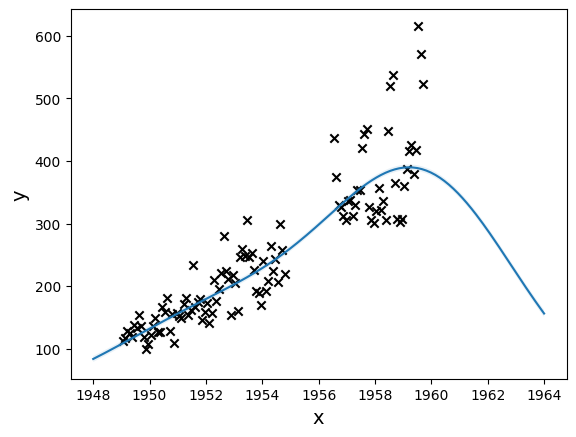

In [25]:
# try RBF kernel
mean_fn = gpytorch.means.ConstantMean()
kernel_fn = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
model = GPRegressor(X_train, y_train, mean_fn, kernel_fn).double() # double precision
train(model, X_train, y_train)
plot_model(model, xlim = [1948, 1964])

### 使用Polynomial Kernel和RBF Kernel 的组合

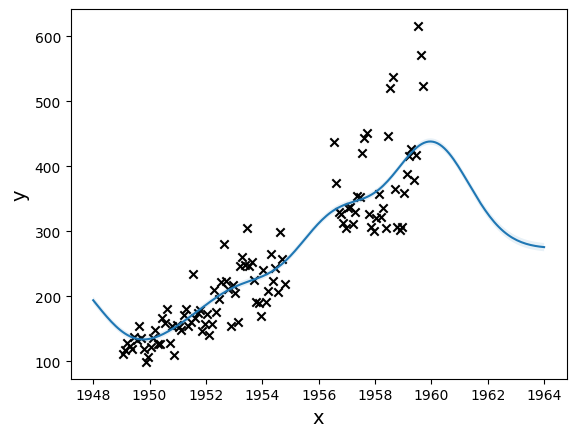

In [17]:
# model trend component
kernel_fn = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power=1)) + \
gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
model = GPRegressor(X_train, y_train, mean_fn, kernel_fn).double()
train(model, X_train, y_train, verbose=False)
plot_model(model, xlim = [1948, 1964])


### 使用趋势核和周期核
趋势核是一个多项式核和一个RBF核的组合，用于捕捉数据的趋势成分。
季节核是一个周期核、一个线性核和一个RBF核的组合，用于捕捉数据的季节性变化。
使用 AdditiveKernel 将趋势核和季节性核组合起来，形成一个综合核，该核同时考虑了数据的趋势和季节性特征。


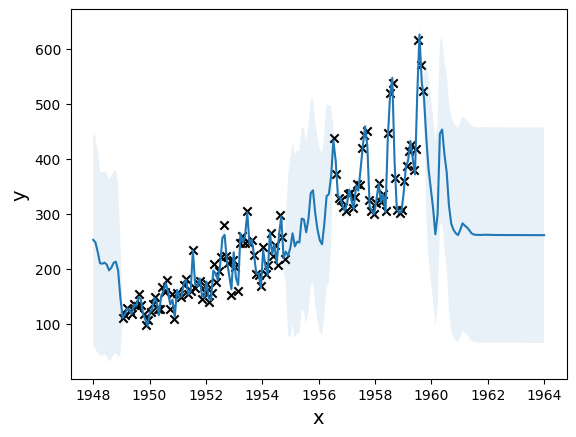

In [21]:
# model trend + periodicity
k_trend = (gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power=1)) +
           gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()))
k_seasonal = (gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()) *
              gpytorch.kernels.LinearKernel() * 
              gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()))
kernel_fn = gpytorch.kernels.AdditiveKernel(k_trend, k_seasonal)
model = GPRegressor(X_train, y_train, mean_fn, kernel_fn).double()
train(model, X_train, y_train, verbose=False)
plot_model(model, xlim = [1948, 1964])

### 使用趋势核、周期核和 异方差噪声

异方差噪声（heteroscedastic noise）是指观测数据中的噪声水平随着数据点的不同而变化的情况。与之相对的是同方差噪声（homoscedastic noise），在这种情况下，所有数据点的噪声水平被认为是相同的。

In [27]:
# model trend + periodicity + heteroscedastic noise
from gpytorch.lazy import DiagLazyTensor

class WhiteNoiseKernel(gpytorch.kernels.Kernel):
    def __init__(self, noise=1):
        super().__init__()
        self.noise = noise
    
    def forward(self, x1, x2, **params):
        if torch.equal(x1, x2):
            return DiagLazyTensor(torch.ones(x1.shape[0]).to(x1) * self.noise)
        else:
            return torch.zeros(x1.shape[0], x2.shape[0]).to(x1)

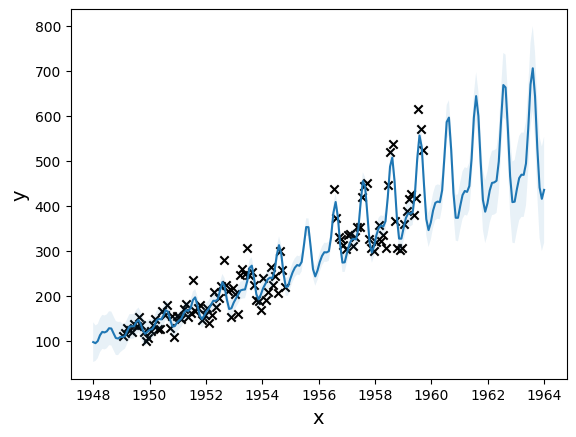

In [28]:
k_noise = gpytorch.kernels.ScaleKernel(WhiteNoiseKernel(noise=0.1)) * gpytorch.kernels.LinearKernel()
kernel_fn = gpytorch.kernels.AdditiveKernel(k_trend, k_seasonal, k_noise)
gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
model = GPRegressor(X_train, y_train, mean_fn, kernel_fn).double()
train(model, X_train, y_train, verbose=False)
plot_model(model, xlim = [1948, 1964])